In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import cartopy.crs as ccrs
import cartopy
import netCDF4 as nc 
import pickle
from matplotlib import gridspec
import os


In [4]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(20/100):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


In [5]:
## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']


SD_uit = np.load('/home/erb/masterproject/MSCI_project/validation_data/UIT_data/snow_201904_EASE2_laku_UIT.npy')


/tmp/ipykernel_124199/633641489.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_124199/633641489.py:13: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]


In [6]:
def snow_OIB(OIB_files):

    SD_OIB = nc.Dataset(OIB_files).variables['Snow Depth'][:,:]
    return SD_OIB

In [7]:
SD_OIB, SD_OIB_awi = [], []
SD_OIB_uit = []
snow_inverse = []
snow_awismos = []
snow_uit = []


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])
    inverse_snow_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy')
    inverse_snow_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow_stddev.npy')

    inverse_snow_data = mask_high_error(inverse_snow_stddev, inverse_snow_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_snow_data[k][j]):
                snow_inverse.append(inverse_snow_data[k][j])
                SD_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_awismos[k][j]):
                snow_awismos.append(SD_awismos[k][j])
                SD_OIB_awi.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_uit[k][j]):
                snow_uit.append(SD_uit[k][j])
                SD_OIB_uit.append(file_OIB[k][j])

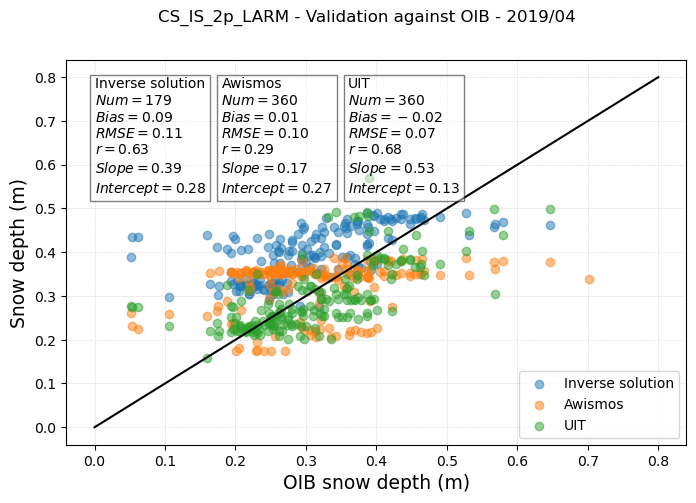

In [8]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')


plt.scatter(SD_OIB, snow_inverse, alpha = 0.5, label = 'Inverse solution')
plt.scatter(SD_OIB_awi, snow_awismos, alpha = 0.5, label = 'Awismos')
plt.scatter(SD_OIB_uit, snow_uit, alpha = 0.5, label = 'UIT')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('OIB snow depth (m)', fontsize = 13.5)
plt.ylabel('Snow depth (m)', fontsize = 13.5)
plt.legend(loc = 'lower right')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, SD_OIB)
r_snow = pearson(SD_OIB, snow_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0, 0.8, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,0.8])
y_values = slope * x_values + intercept


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_awismos, SD_OIB_awi)
r_snow = pearson(SD_OIB_awi, snow_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(SD_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.18, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_uit, SD_OIB_uit)
r_snow = pearson(SD_OIB_uit, snow_uit)

textstr = '\n'.join((
    rf'UIT',
    rf'$Num = {len(SD_uit)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.36, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept

